# ACML Assignment 2 - Neural Network
## Brenton Budler - 1827655

The implementation of the Neural Network will be carried out on the Sonar Dataset from the UCI Repository of Machine Learning. The task is to a train a neural network to discriminate between sonar signals bounced off a metal cylinder (a mine) and those bounced off a rough sylindrical rock. 

Each pattern is a set of 60 numbers in the tange of 0.0 to 1.0 and each number represents the energy within a particular frequencty band, integrated over a certain period of time. The label associated with each record contains the letter "R" if the object is a rock and "M" if it is a mine. 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import timeit

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## 1. Data Ingestion

In [2]:
df = pd.read_csv('sonar.csv',header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


## 2. Exploratory Data Analysis 

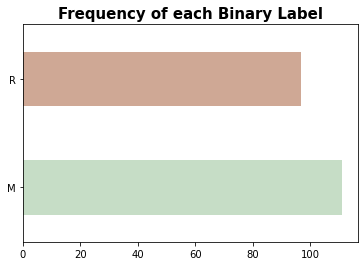

In [3]:
df[60].value_counts().plot(kind='barh', color=["darkseagreen","sienna"],alpha=0.5)
plt.title("Frequency of each Binary Label", fontsize=15, fontweight = "bold")
plt.show()

As we can see there is a similar frequency of each class instance in the dataset meaning the dataset is relatively well balanced. 

## 3. Data Preprocessing

Due to each value already being between 0.0 and 1.0 there is no need for scaling or normalizing the data. However we still need to use one-hot enconding to ensure our tager column is in the correct form.

In [4]:
map_dict = {"R":1, "M":0}
df.iloc[:,60] = df.iloc[:,60].map(map_dict)
df=df.rename(columns = {60:'target'})

## 4. Model Construction 

### 4.1 Different Activation Functions and their Derivatives

In [5]:
# Linear Activation Function
def linear(x):
    return x
def d_linear(x):
    return 1

# Sigmoid Activation Function
def sigmoid(x):
    return 1/(1+np.exp(-x))
def d_sigmoid(x):
    return (1 - sigmoid(x))*sigmoid(x)

# Hyperbolic Tangent Activation Function 
def tanh(x):
    return np.tanh(x)
def d_tanh(x):
    return 1 - np.square(np.tanh(x))

# Rectified Linear Unit Activation Function 
def ReLU(x):
    return np.maximum(0,x)
def d_ReLU(x):
    return x>0

### 4.2 Defining Loss Function 

In [6]:
# Using log loss as it is a binary classification problem 
def logloss(y, a):
    return -(y*np.log(a) + (1-y)*np.log(1-a))
def d_logloss(y, a):
    return (a-y)/(a*(1-a))

### 4.3 Creation of Layer Class

In [7]:
# Layer Class 
class Layer:
    
    # Dictionary to reference our different activation functions 
    activationFunctions = {
        'tanh' : (tanh, d_tanh),
        'sigmoid' : (sigmoid, d_sigmoid),
        'linear' : (linear, d_linear),
        'relu' : (ReLU, d_ReLU),
    }
    
    learning_rate = 0.1
    
    def __init__(self, inputs, neurons, activation):
        # Initialize weights and biases 
        self.W = np.random.randn(neurons, inputs)
        self.b = np.zeros((neurons,1))
        self.act, self.d_act = self.activationFunctions.get(activation)
        
    def feedforward(self, A_prev):
        '''
        Performs one step of feed forward through a layer 
        Input: The output from the previous layer (or the original inputs in the case that this is layer 1)
        Output: The weighted sum of the input values plus the bias after being passed through the activation function
        '''
        # Store the original values as they will be used in the backpropagation 
        self.A_prev = A_prev
        
        # Calculate Weights multiplied by values plus bias (Z = W*A + b)
        self.Z = np.dot(self.W, self.A_prev) + self.b 
        
        # Now we find the output of this laeyr by passing it through the activation function 
        self.A = self.act(self.Z)
        return self.A
        
    def backprop(self, dA):
        '''
        Calculates the necessary partial derivatives needed to perform back propagation 
        and adjusts the weights and biases accordignly
        Input: partial derivative of activation of current layer 
        Output: partial derivative of activation of previous layer 
        '''
        
        # All derivatives are with respect to the cost function (therefore dC/dZ will simply be dZ)
        dZ = np.multiply(self.d_act(self.Z), dA)
        
        # Weight derivative, divided by the number of samples to get the average across all samples 
        dW = 1/dZ.shape[1] * np.dot(dZ, self.A_prev.T)
        
        # Bias derivatives, the summation is done to ensure the array is of the correct shape 
        db = 1/dZ.shape[1] * np.sum(dZ, axis=1, keepdims = True)
        
        # Finding the derivative to pass to the previous layer
        dA_prev = np.dot(self.W.T, dZ)
        
        # Updating our weights and biases using Gradient Descent 
        self.W = self.W - self.learning_rate * dW
        self.b = self.b - self.learning_rate * db
    
        return dA_prev
        
         

### 4.4 Creation of Neural Network Method 

In [8]:
def Neural_Network(m, epochs , layers, X, y):
    costs = []
    accs = [] 
    
    for epoch in range(epochs):
    
        # Define input
        A = X

        # Do a forward pass of each layer
        for layer in layers:
            # Output of each layer becomes input to next layer in feedforward
            A = layer.feedforward(A)

        # Calculate the cost function for this iteration 
        # Cost calculated as the average loss for each sample (comparing predicted and actual value)
        cost = 1/m * np.sum(logloss(y, A))
        costs.append(cost)
        
        # Accuracy Calculation 
        predictions = A.T
        predictions = predictions.reshape(predictions.shape[0],)
        predictions = (predictions > 0.5).astype(int)
        accuracy = np.mean(predictions==y)    
        accs.append(accuracy)

        # Calculate the derivative of the output with respect to the cost 
        dA = d_logloss(y, A)

        # Now we can before back propagation, starting with the last layer and working in reverse 
        for layer in reversed(layers):
            dA = layer.backprop(dA)

    return costs,accs

### 4.5 Model Training

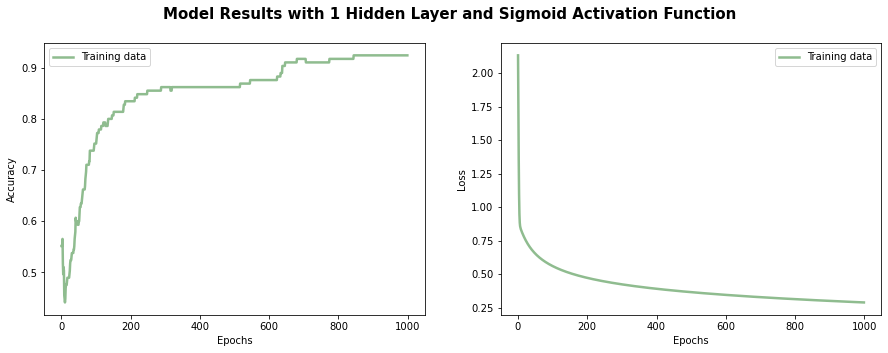

In [9]:
from sklearn.model_selection import train_test_split


X = np.array(df.drop("target",axis=1))
y = np.array(df["target"]).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.3)
m = len(X_train)
X_train, X_test = X_train.T, X_test.T

epochs = 1000

# Plot to e
fig, axs = plt.subplots(1,2,figsize=(15,5))

# Construction of a Neural Network using one hidden layer and the sigmoid activation function 
layers = [Layer(60, 60, 'sigmoid') , Layer(60,1,'sigmoid')]
costs,accs  = Neural_Network(m, epochs, layers , X_train, y_train )
axs[0].plot(range(epochs), accs, label='Training data', color ='darkseagreen', lw=2.5)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

axs[1].plot(range(epochs), costs, label='Training data', color ='darkseagreen', lw =2.5)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].legend()

fig.suptitle('Model Results with 1 Hidden Layer and Sigmoid Activation Function',fontsize=15, fontweight='bold')
plt.show()

## 4.5 Model Evaluation 

              precision    recall  f1-score   support

           0       0.90      0.84      0.87        31
           1       0.85      0.91      0.88        32

    accuracy                           0.87        63
   macro avg       0.87      0.87      0.87        63
weighted avg       0.87      0.87      0.87        63



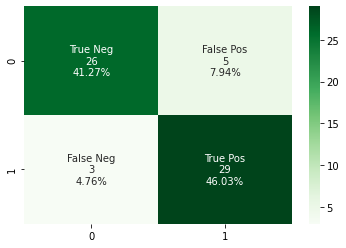

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Model evaluation done using a threshold of 0.5 for classification 
A = X_test
for layer in layers:
    A = layer.feedforward(A)
y_pred = A.reshape(y_test.shape)
y_pred = (y_pred>0.5).astype(int)

print(classification_report(y_test,y_pred))
cf_matrix = confusion_matrix(y_test,y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens')
plt.show()

## 5. Exploring the effect of different activation functions 

For the binary classification task, we maintain a sigmoid activation function for the output layer to perfrom however we can adjust which activation function we use for the hidden layers to explore how this effects our accruacy and cost during training

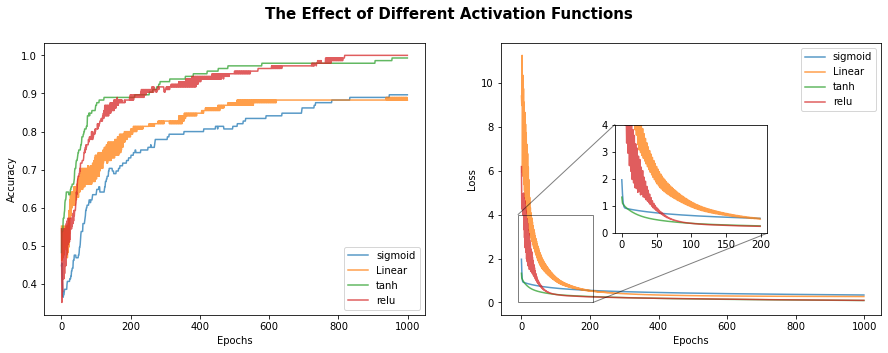

In [15]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axin1 = axs[1].inset_axes([0.3, 0.3, 0.4, 0.4])
axin1.set_ylim(0,4)


layers = [Layer(60, 60, 'sigmoid') , Layer(60,1,'sigmoid')]
costs,accs  = Neural_Network(m, epochs, layers , X_train, y_train )
axs[0].plot(range(epochs), accs, label='sigmoid', alpha=0.75)
axs[1].plot(range(epochs), costs, label='sigmoid', alpha=0.75)
axin1.plot(range(200), costs[:200], label='sigmoid', alpha=0.75)

layers = [Layer(60, 60, 'linear') , Layer(60,1,'sigmoid')]
costs,accs  = Neural_Network(m, epochs, layers , X_train, y_train )
axs[0].plot(range(epochs), accs, label='Linear', alpha=0.75)
axs[1].plot(range(epochs), costs, label='Linear', alpha=0.75)
axin1.plot(range(200), costs[:200], label='Linear', alpha=0.75)

layers = [Layer(60, 60, 'tanh') , Layer(60,1,'sigmoid')]
costs,accs  = Neural_Network(m, epochs, layers , X_train, y_train )
axs[0].plot(range(epochs), accs, label='tanh', alpha=0.75)
axs[1].plot(range(epochs), costs, label='tanh', alpha=0.75)
axin1.plot(range(200), costs[:200], label='tanh', alpha=0.75)


layers = [Layer(60, 60, 'relu') , Layer(60,1,'sigmoid')]
costs,accs  = Neural_Network(m, epochs, layers , X_train, y_train )
axs[0].plot(range(epochs), accs, label='relu', alpha=0.75)
axs[1].plot(range(epochs), costs, label='relu', alpha=0.75)
axin1.plot(range(200), costs[:200], label='relu', alpha=0.75)

#axs[0].set_title("Accuracy")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")

#axs[1].set_title("Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")


axs[0].legend()
axs[1].legend()


axs[1].indicate_inset_zoom(axin1, edgecolor="black")

fig.suptitle('The Effect of Different Activation Functions',fontsize=15, fontweight='bold')
plt.show()

## 6. Exploring the effect of network size on generalizability 

In order to explore the effect of varying network architectures we will use the same activation function (The Sigmoid Activation Function) throughout the exploration whilst varying the network parameters such as the number of hidden layers or the number of nodes per hidden layer.

In [16]:
def metrics(layers, X_test, y_test):
    '''
    A function that allows for the calculation of a given network architecture's accruacy 
    On both the training data and the testing data 
    Input: Layers of the Neural Network, Training data 
    Output: Training Accuracy, Testing Accuracy (using a threshold of 0.5 for classification)
    '''
    costs,accs  = Neural_Network(m, epochs, layers , X_train, y_train )

    # Cost Calculation 
    A = X_test
    for layer in layers:
        A = layer.feedforward(A)
    y_pred = A.reshape(y_test.shape)
 #   cost = 1/len(y_pred) * np.sum(logloss(y_pred, A))

    # Accuracy Calculation
    predictions = A.T
    predictions = predictions.reshape(predictions.shape[0],)
    predictions = (predictions > 0.5).astype(int)
    accuracy = np.mean(predictions==y_test)  
    
    return accs[-1],accuracy

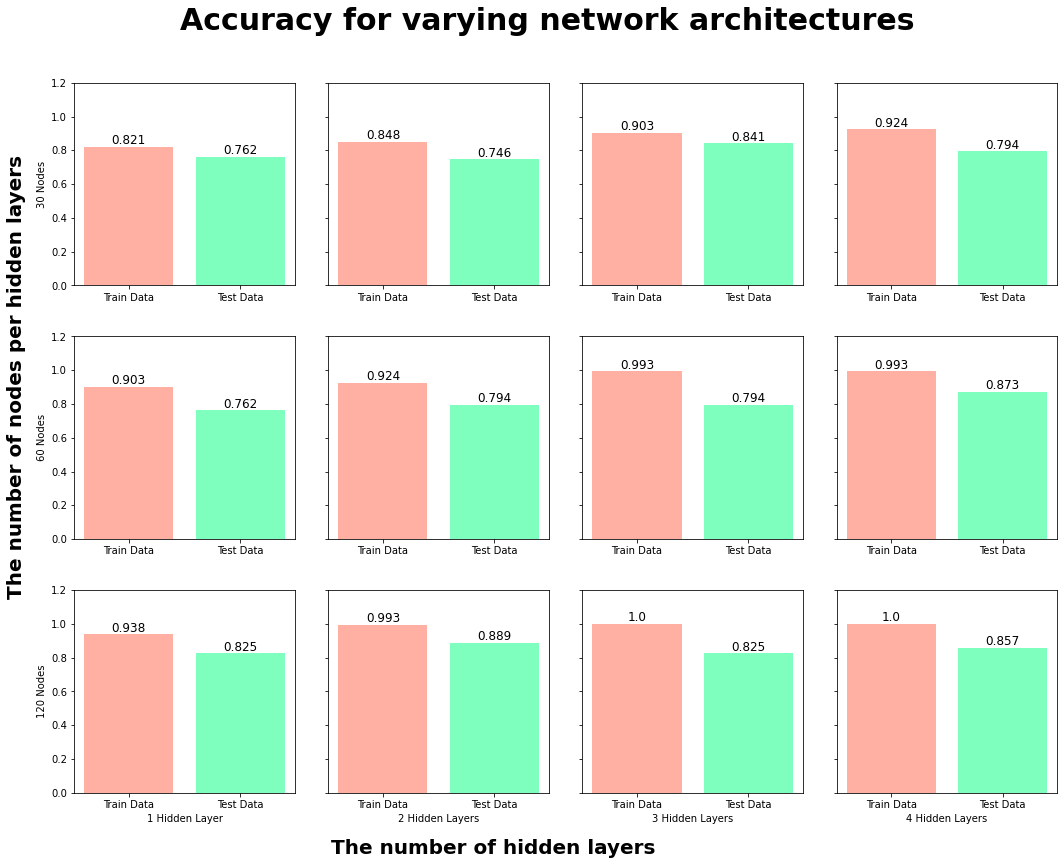

In [17]:
fig, axs = plt.subplots(3,4,figsize=(15,12), sharey=True)

# First Row
layers = [Layer(60, 30, 'sigmoid') , Layer(30,1,'sigmoid')]
res = metrics(layers, X_test, y_test)
cat = ["Train Data","Test Data"]
axs[0,0].bar(cat, res, color = ['tomato', 'springgreen'], alpha=0.5)
axs[0,0].set_ylim(0,1.2)
axs[0,0].set_ylabel("30 Nodes")
for i in range(len(res)):
    axs[0,0].annotate(str(round(res[i],3)), xy=(cat[i],res[i]), ha='center', va='bottom', fontsize=12)

layers = [Layer(60, 30, 'sigmoid') , Layer(30,30,'sigmoid'), Layer(30,1,'sigmoid')]
res = metrics(layers, X_test, y_test)
cat = ["Train Data","Test Data"]
axs[0,1].bar(cat, res, color = ['tomato', 'springgreen'], alpha=0.5)
axs[0,1].set_ylim(0,1.2)
for i in range(len(res)):
    axs[0,1].annotate(str(round(res[i],3)), xy=(cat[i],res[i]), ha='center', va='bottom', fontsize=12)
    
layers = [Layer(60, 30, 'sigmoid') , Layer(30,30,'sigmoid'), Layer(30,30,'sigmoid'), Layer(30,1,'sigmoid')]
res = metrics(layers, X_test, y_test)
cat = ["Train Data","Test Data"]
axs[0,2].bar(cat, res, color = ['tomato', 'springgreen'], alpha=0.5)
axs[0,2].set_ylim(0,1.2)
for i in range(len(res)):
    axs[0,2].annotate(str(round(res[i],3)), xy=(cat[i],res[i]), ha='center', va='bottom', fontsize=12)
    
layers = [Layer(60, 30, 'sigmoid') , Layer(30,30,'sigmoid'),Layer(30,30,'sigmoid'), Layer(30,30,'sigmoid'), Layer(30,1,'sigmoid')]
res = metrics(layers, X_test, y_test)
cat = ["Train Data","Test Data"]
axs[0,3].bar(cat, res, color = ['tomato', 'springgreen'], alpha=0.5)
axs[0,3].set_ylim(0,1.2)
for i in range(len(res)):
    axs[0,3].annotate(str(round(res[i],3)), xy=(cat[i],res[i]), ha='center', va='bottom', fontsize=12)
    
# Second Row
layers = [Layer(60, 60, 'sigmoid') , Layer(60,1,'sigmoid')]
res = metrics(layers, X_test, y_test)
cat = ["Train Data","Test Data"]
axs[1,0].bar(cat, res, color = ['tomato', 'springgreen'], alpha=0.5)
axs[1,0].set_ylim(0,1.2)
axs[1,0].set_ylabel("60 Nodes")
for i in range(len(res)):
    axs[1,0].annotate(str(round(res[i],3)), xy=(cat[i],res[i]), ha='center', va='bottom', fontsize=12)

layers = [Layer(60, 60, 'sigmoid') , Layer(60,60,'sigmoid'), Layer(60,1,'sigmoid')]
res = metrics(layers, X_test, y_test)
cat = ["Train Data","Test Data"]
axs[1,1].bar(cat, res, color = ['tomato', 'springgreen'], alpha=0.5)
axs[1,1].set_ylim(0,1.2)
for i in range(len(res)):
    axs[1,1].annotate(str(round(res[i],3)), xy=(cat[i],res[i]), ha='center', va='bottom', fontsize=12)
    
layers = [Layer(60, 60, 'sigmoid') , Layer(60,60,'sigmoid'), Layer(60,60,'sigmoid'), Layer(60,1,'sigmoid')]
res = metrics(layers, X_test, y_test)
cat = ["Train Data","Test Data"]
axs[1,2].bar(cat, res, color = ['tomato', 'springgreen'], alpha=0.5)
axs[1,2].set_ylim(0,1.2)
for i in range(len(res)):
    axs[1,2].annotate(str(round(res[i],3)), xy=(cat[i],res[i]), ha='center', va='bottom', fontsize=12)
    
layers = [Layer(60, 60, 'sigmoid') , Layer(60,60,'sigmoid'), Layer(60,60,'sigmoid'), Layer(60,60,'sigmoid'), Layer(60,1,'sigmoid')]
res = metrics(layers, X_test, y_test)
cat = ["Train Data","Test Data"]
axs[1,3].bar(cat, res, color = ['tomato', 'springgreen'], alpha=0.5)
axs[1,3].set_ylim(0,1.2)
for i in range(len(res)):
    axs[1,3].annotate(str(round(res[i],3)), xy=(cat[i],res[i]), ha='center', va='bottom', fontsize=12)
    
# Third Row
layers = [Layer(60, 120, 'sigmoid') , Layer(120,1,'sigmoid')]
res = metrics(layers, X_test, y_test)
cat = ["Train Data","Test Data"]
axs[2,0].bar(cat, res, color = ['tomato', 'springgreen'], alpha=0.5)
axs[2,0].set_ylim(0,1.2)
axs[2,0].set_ylabel("120 Nodes")
axs[2,0].set_xlabel("1 Hidden Layer")
for i in range(len(res)):
    axs[2,0].annotate(str(round(res[i],3)), xy=(cat[i],res[i]), ha='center', va='bottom', fontsize=12)

layers = [Layer(60, 120, 'sigmoid') , Layer(120,120,'sigmoid'), Layer(120,1,'sigmoid')]
res = metrics(layers, X_test, y_test)
cat = ["Train Data","Test Data"]
axs[2,1].bar(cat, res, color = ['tomato', 'springgreen'], alpha=0.5)
axs[2,1].set_ylim(0,1.2)
axs[2,1].set_xlabel("2 Hidden Layers")
for i in range(len(res)):
    axs[2,1].annotate(str(round(res[i],3)), xy=(cat[i],res[i]), ha='center', va='bottom', fontsize=12)
    
layers = [Layer(60, 120, 'sigmoid') , Layer(120,120,'sigmoid'), Layer(120,120,'sigmoid'), Layer(120,1,'sigmoid')]
res = metrics(layers, X_test, y_test)
cat = ["Train Data","Test Data"]
axs[2,2].bar(cat, res, color = ['tomato', 'springgreen'], alpha=0.5)
axs[2,2].set_ylim(0,1.2)
axs[2,2].set_xlabel("3 Hidden Layers")
for i in range(len(res)):
    axs[2,2].annotate(str(round(res[i],3)), xy=(cat[i],res[i]), ha='center', va='bottom', fontsize=12)
    
layers = [Layer(60, 120, 'sigmoid') , Layer(120,120,'sigmoid'),Layer(120,120,'sigmoid'), Layer(120,120,'sigmoid'), Layer(120,1,'sigmoid')]
res = metrics(layers, X_test, y_test)
cat = ["Train Data","Test Data"]
axs[2,3].bar(cat, res, color = ['tomato', 'springgreen'], alpha=0.5)
axs[2,3].set_ylim(0,1.2)
axs[2,3].set_xlabel("4 Hidden Layers")
for i in range(len(res)):
    axs[2,3].annotate(str(round(res[i],3)), xy=(cat[i],res[i]), ha='center', va='bottom', fontsize=12)
    
    
fig.suptitle('Accuracy for varying network architectures', fontsize=30, fontweight='bold')
fig.text(0.3,0, "The number of hidden layers", fontsize=20,  fontweight='bold')
fig.text(0,0.3, "The number of nodes per hidden layers", fontsize=20, rotation=90,  fontweight='bold')
plt.tight_layout(pad=3)
plt.show()

We can see that by adjusting various network parameters we are able to increase accuracy. However, sometimes increassing the number of nodes in a layer or the number of hidden layers will increase the accuracy on the training data but result in a decrease in the accuracy for the testing data, this is evident of overfitting meaning our model is not able to generalize well. In this evaluation we assumed that all the hidden layers in a given network architecture had the same number of nodes, let us explore the effect of having varying number of nodes in each layer. 

In [18]:
import time 

# One hidden layer, only changing the number of nodes 
arch1 = pd.DataFrame(columns=["Architecture","Train Acc","Test Acc","Time(s)"])
arch1["Architecture"] = ["(30,60)","(30,60,120)" , "(30,60,60,120)","(120,60)","(120,60,30)","(120,60,60,30)"]


layers = [Layer(60, 30, 'sigmoid') , Layer(30,60,'sigmoid'), Layer(60, 1, 'sigmoid')]
start = time.perf_counter()
arch1.loc[0,["Train Acc","Test Acc"]] = metrics(layers, X_test, y_test)
stop = time.perf_counter()
arch1.loc[0,"Time(s)"] = stop -start

layers = [Layer(60, 30, 'sigmoid') , Layer(30, 60, 'sigmoid'),Layer(60, 120, 'sigmoid'), Layer(120,1,'sigmoid')]
start = time.perf_counter()
arch1.loc[1,["Train Acc","Test Acc"]] = metrics(layers, X_test, y_test)
stop = time.perf_counter()
arch1.loc[1,"Time(s)"] = stop -start

layers = [Layer(60, 30, 'sigmoid') , Layer(30, 60, 'sigmoid'),Layer(60, 60, 'sigmoid') ,Layer(60, 120, 'sigmoid'), Layer(120,1,'sigmoid')]
start = time.perf_counter()
arch1.loc[2,["Train Acc","Test Acc"]] = metrics(layers, X_test, y_test)
stop = time.perf_counter()
arch1.loc[2,"Time(s)"] = stop -start

layers = [Layer(60, 120, 'sigmoid') , Layer(120,60,'sigmoid'), Layer(60, 1, 'sigmoid')]
start = time.perf_counter()
arch1.loc[3,["Train Acc","Test Acc"]] = metrics(layers, X_test, y_test)
stop = time.perf_counter()
arch1.loc[3,"Time(s)"] = stop -start

layers = [Layer(60, 120, 'sigmoid') , Layer(120, 60, 'sigmoid'),Layer(60, 30, 'sigmoid'), Layer(30,1,'sigmoid')]
start = time.perf_counter()
arch1.loc[4,["Train Acc","Test Acc"]] = metrics(layers, X_test, y_test)
stop = time.perf_counter()
arch1.loc[4,"Time(s)"] = stop -start

layers = [Layer(60, 120, 'sigmoid') , Layer(120, 60, 'sigmoid'),Layer(60, 60, 'sigmoid') ,Layer(60, 30, 'sigmoid'), Layer(30,1,'sigmoid')]
start = time.perf_counter()
arch1.loc[5,["Train Acc","Test Acc"]] = metrics(layers, X_test, y_test)
stop = time.perf_counter()
arch1.loc[5,"Time(s)"] = stop -start

display(arch1)

,Architecture,Train Acc,Test Acc,Time(s)
0,"(30,60)",0.931034,0.793651,0.79971
1,"(30,60,120)",0.951724,0.793651,1.52912
2,"(30,60,60,120)",0.965517,0.825397,2.0022
3,"(120,60)",0.993103,0.825397,1.25685
4,"(120,60,30)",0.986207,0.793651,1.48978
5,"(120,60,60,30)",1,0.793651,1.87461


We can see that by changing the number of nodes per layer we are able to attain results comparable to those attained by keeping the same number of nodes per layer. This evaluation also allows us to see that an increase in network complexity also leads to an increase in training time. Through the creation of a neural network from basic principles we have been able to explore how these networks are constructed, how they go about adjusting their parameters through backrpopagation and gradient descent and how their hyperparameters can be adjusted to attain better results. We also explored the important role that the activation function plays and how it can effect model training. The best results obtained experimentally were 99.3% training accuracy and 88.9% testing accuracy using 2 Hidden Layers with 120 nodes per layer.